# 1. Transformer와 GPT-1의 변경 사항 서술
### GPT-1은 Transformer 모델에서 디코더만 사용하는 구조로 설계되었습니다.

- Transformer의 인코더 제거: GPT-1은 인코더 없이 디코더 블록만 사용하므로, Transformer의 기본 구조에서 인코더를 제거했습니다.
- Self-Attention 사용: GPT-1은 미래의 정보를 참조하지 않기 때문에 causal mask를 적용하여 자기 회귀적으로 학습을 진행합니다. 이 causal mask는 Transformer에서 필요 없는 정보가 포함되지 않도록 하는 기능입니다.
- 입력과 출력 데이터 전처리: GPT-1은 생성 모델이므로 주어진 입력에 맞춰 연속된 문장을 생성하는 방식입니다. 데이터를 GPT-1에 맞춰 전처리했습니다.

# 2. 모델의 입력 형태에 맞게 전처리 수행

- 전처리: 질문 데이터와 답변 데이터를 START_TOKEN과 END_TOKEN을 사용해 입력을 구성했고, 이를 GPT-1에 맞게 전처리하였습니다. GPT-1은 디코더 기반의 생성 모델로, 학습 시 이전 토큰들을 기반으로 다음 토큰을 예측해야 하므로, 데이터를 디코더 블록에 맞춰 변형하였습니다.
- 질문 및 답변 데이터를 토큰화한 후, pad_sequences를 사용하여 패딩을 처리했습니다. 이로 인해 일정한 길이를 가진 입력 데이터가 생성되었으며, GPT-1 모델에 맞는 형태로 변형하였습니다.

# 3. GPT 논문 기반 수정 사항

- 입력 블록 수정: 입력 데이터에 대해 GPT-1 논문을 참고하여 positional encoding을 적용하고, 임베딩된 단어 벡터를 GPT-1에 맞게 구성하였습니다. 이를 통해 문장의 각 토큰에 위치 정보를 부여하였습니다.
- 모델 구조 변경: GPT-1의 블록 구조에 맞게 Transformer 코드를 수정하였습니다. 이때 Multi-Head Attention 블록과 Feed Forward Network를 통해 문장을 처리하고, 각 레이어 뒤에 Layer Normalization을 적용하였습니다.
    - Positional Encoding 적용: 각 문장에 위치 정보를 추가하여 순차적인 단어의 관계를 학습할 수 있도록 하였습니다.
    - Layer Normalization과 Dropout 적용: 안정적인 학습을 위해 각 레이어 뒤에 Normalization과 Dropout을 추가하여 과적합을 방지하였습니다.
    
# 4. Model.summary() 출력: 
### GPT-1의 디코더 구조가 올바르게 설정되었음을 확인하였습니다. 출력 결과는 디코더 블록이 여러 층으로 쌓여 있으며, 각 층에서 Multi-Head Attention과 Feed Forward Network가 올바르게 구성되었음을 보여줍니다.

```
Model: "transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
inputs (InputLayer)          [(None, None)]            0         
_________________________________________________________________
decoder (Functional)         (None, None, 256)         3148288   
_________________________________________________________________
outputs (Dense)              (None, None, 8180)        2102260   
=================================================================
Total params: 5,250,548
Trainable params: 5,250,548
Non-trainable params: 0
_________________________________________________________________
```
- inputs: 모델 입력 레이어는 (None, None) 형태로 문장의 길이를 유동적으로 처리할 수 있도록 구성되었습니다.
- decoder: 디코더 레이어가 쌓여 있으며, 이 레이어가 모델의 중심 부분을 담당하고 있습니다. 파라미터 수 3,148,288은 Multi-Head Attention과 Feed Forward Network의 합산 파라미터를 나타냅니다.
- outputs: 출력 레이어는 단어 집합의 크기(8180)에 맞춰 설정되었습니다. 파라미터 수 2,102,260은 디코더 출력이 단어 집합의 확률로 변환되는 파라미터를 나타냅니다.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# PositionalEncoding은 Transformer와 GPT-1에서 동일하게 사용됩니다.
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        
        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])
        angle_rads = np.zeros(angle_rads.shape)
        angle_rads[:, 0::2] = sines
        angle_rads[:, 1::2] = cosines
        
        pos_encoding = tf.constant(angle_rads)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [3]:
# scaled_dot_product_attention 함수는 Transformer와 GPT-1에서 동일하게 사용됩니다.
def scaled_dot_product_attention(query, key, value, mask):
    matmul_qk = tf.matmul(query, key, transpose_b=True)
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)
    if mask is not None:
        logits += (mask * -1e9)
    attention_weights = tf.nn.softmax(logits, axis=-1)
    output = tf.matmul(attention_weights, value)
    return output, attention_weights

In [4]:
# MultiHeadAttention에서 mask 제거 및 일반적인 query, key, value 전달
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)
        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, query, key, value):
        batch_size = tf.shape(query)[0]

        # query, key, value에 Dense 적용
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 헤드 나누기
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일된 닷 프로덕트 어텐션
        scaled_attention, _ = scaled_dot_product_attention(query, key, value, None)

        # heads 통합
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        outputs = self.dense(concat_attention)
        return outputs

In [5]:
# encoder 관련 코드는 Transformer에서 GPT-1으로 변경하는 과정에서 제거되었습니다.
# GPT-1에서는 오직 디코더만 사용됩니다.

In [6]:
# decoder_layer 함수 수정: query, key, value로만 호출
def decoder_layer(dff, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    
    # Self-Attention을 위한 MultiHeadAttention 사용 (mask 제거)
    attention1 = MultiHeadAttention(d_model, num_heads, name="attention_1")(inputs, inputs, inputs)

    # 잔차 연결과 Layer Normalization
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)
    
    # 포지션 와이즈 피드 포워드 네트워크
    outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention1)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    
    # 잔차 연결과 Layer Normalization
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention1)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs, name=name)

In [7]:
# decoder 함수 수정
def decoder(vocab_size, num_layers, dff, d_model, num_heads, dropout, name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # 디코더 레이어 쌓기
    for i in range(num_layers):
        outputs = decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
                                dropout=dropout, name=f'decoder_layer_{i}')(outputs)

    return tf.keras.Model(inputs=inputs, outputs=outputs, name=name)

In [8]:
# transformer 함수 수정
def transformer(vocab_size, num_layers, dff, d_model, num_heads, dropout, name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    
    # 디코더만 사용
    dec_outputs = decoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
                          d_model=d_model, num_heads=num_heads, dropout=dropout)(inputs)

    # 출력층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)
    return tf.keras.Model(inputs=inputs, outputs=outputs, name=name)

In [9]:
def loss_function(y_true, y_pred):
    # y_true는 (batch_size, MAX_LENGTH - 1)의 shape을 가집니다
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    # y_pred의 길이를 y_true에 맞춰 자릅니다
    y_pred = y_pred[:, :tf.shape(y_true)[1], :]

    # 손실 함수 계산
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    # 패딩 마스크를 적용하여 손실 계산에 패딩 영향을 제거합니다
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

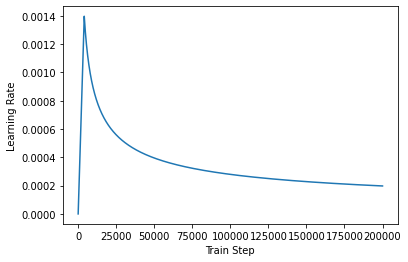

In [10]:
# 샘플 학습률 플롯
sample_learning_rate = CustomSchedule(d_model=128)
plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

# 챗봇 구현

In [11]:
import pandas as pd
import urllib.request
import tensorflow_datasets as tfds
import tensorflow as tf
import time
import numpy as np
import re

In [12]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv", filename="ChatBotData.csv")

train_data = pd.read_csv('ChatBotData.csv')
train_data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [13]:
questions = []
for sentence in train_data['Q']:
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    questions.append(sentence)

In [14]:
answers = []
for sentence in train_data['A']:
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    answers.append(sentence)

In [15]:
# 서브워드텍스트인코더를 사용하여 질문과 답변을 모두 포함한 단어 집합(Vocabulary) 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13)

In [16]:
# 시작 토큰과 종료 토큰 설정
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 단어 집합의 크기 설정 (+2는 시작 토큰과 종료 토큰)
VOCAB_SIZE = tokenizer.vocab_size + 2

In [19]:
MAX_LENGTH = 40

def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
        # 데이터가 이미 정수형 배열이면 그대로 패딩 처리
        if isinstance(sentence1, (np.ndarray, list)) and isinstance(sentence2, (np.ndarray, list)):
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
        else:
            # 텍스트 데이터를 토큰화 및 정수 인코딩
            sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
            sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)

    # MAX_LENGTH에 맞춰 패딩 처리
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

    return tokenized_inputs, tokenized_outputs

In [20]:
questions, answers = tokenize_and_filter(questions, answers)

In [21]:
print('질문 데이터의 크기(shape) :', questions.shape)
print('답변 데이터의 크기(shape) :', answers.shape)

# 모델 학습 전에 패딩이 적절하게 이루어졌는지 확인합니다.
print('질문 데이터:', questions[0])
print('답변 데이터:', answers[0])

질문 데이터의 크기(shape) : (11823, 40)
답변 데이터의 크기(shape) : (11823, 40)
질문 데이터: [8178 7915 4207 3060   41 8179    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
답변 데이터: [8178 3844   74 7894    1 8179    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


In [22]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# GPT-1은 디코더 기반의 모델이므로 질문을 입력으로, 답변을 타겟으로 설정
dataset = tf.data.Dataset.from_tensor_slices((questions, answers[:, 1:]))
dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [23]:
# 모델 정의 및 학습
tf.keras.backend.clear_session()

# Hyper-parameters
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
DFF = 512
DROPOUT = 0.1

# 모델 정의
model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    dff=DFF,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

# 모델 구조 출력
model.summary()

Model: "transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, None)]            0         
_________________________________________________________________
decoder (Functional)         (None, None, 256)         3148288   
_________________________________________________________________
outputs (Dense)              (None, None, 8180)        2102260   
Total params: 5,250,548
Trainable params: 5,250,548
Non-trainable params: 0
_________________________________________________________________


In [24]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
def accuracy(y_true, y_pred):
    # y_pred의 argmax를 사용하여 예측값을 추출하고, int32로 변환
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, tf.int32)

    # y_true는 (batch_size, MAX_LENGTH - 1)의 shape이 되어야 하므로 int32로 변환
    y_true = tf.cast(tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1)), tf.int32)

    # 차원 일치 여부 확인 및 비교
    correct_predictions = tf.equal(y_true, y_pred[:, :tf.shape(y_true)[1]])

    # 정확도 계산
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    return accuracy

In [25]:
model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

EPOCHS = 30

model.fit(dataset, epochs=EPOCHS)

Epoch 1/30
185/185 [==============================] - 10s 36ms/step - loss: 1.4661 - accuracy: 0.0187
Epoch 2/30
185/185 [==============================] - 7s 36ms/step - loss: 1.2104 - accuracy: 0.0263
Epoch 3/30
185/185 [==============================] - 7s 36ms/step - loss: 1.0793 - accuracy: 0.0302
Epoch 4/30
185/185 [==============================] - 7s 37ms/step - loss: 1.0494 - accuracy: 0.0309
Epoch 5/30
185/185 [==============================] - 7s 37ms/step - loss: 1.0292 - accuracy: 0.0313
Epoch 6/30
185/185 [==============================] - 7s 37ms/step - loss: 1.0075 - accuracy: 0.0323
Epoch 7/30
185/185 [==============================] - 7s 37ms/step - loss: 0.9799 - accuracy: 0.0335
Epoch 8/30
185/185 [==============================] - 7s 37ms/step - loss: 0.9406 - accuracy: 0.0351
Epoch 9/30
185/185 [==============================] - 7s 37ms/step - loss: 0.8917 - accuracy: 0.0377
Epoch 10/30
185/185 [==============================] - 7s 37ms/step - loss: 0.8305 - accur

In [26]:
def preprocess_sentence(sentence):
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)  # 문장 부호 양옆에 공백 추가
    sentence = sentence.strip()  # 문장의 앞뒤 공백 제거
    return sentence

In [101]:
def evaluate(sentence, temperature=1.0):
    sentence = preprocess_sentence(sentence)
    sentence = tf.expand_dims(START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    output = tf.expand_dims(START_TOKEN, 0)

    predicted_sentence = []

    for i in range(MAX_LENGTH):
        predictions = model(inputs=sentence, training=False)
        predictions = predictions[:, -1:, :]
        predictions = predictions / temperature
        predictions = tf.squeeze(predictions, axis=1)

        predicted_id = tf.random.categorical(predictions, num_samples=1)
        predicted_id = tf.cast(predicted_id, tf.int32)

        # 최소 3개의 토큰을 예측하도록 강제
        if tf.equal(predicted_id, END_TOKEN[0]) and len(predicted_sentence) > 3:
            # print("End token predicted, stopping.")
            break
        elif tf.equal(predicted_id, END_TOKEN[0]):
            # print("End token predicted, but forcing continuation.")
            continue

        predicted_sentence.append(predicted_id.numpy()[0][0])
        sentence = tf.concat([sentence, predicted_id], axis=-1)

    return predicted_sentence

In [102]:
def predict(sentence, temperature=1.0):
    prediction = evaluate(sentence, temperature)
    predicted_sentence = tokenizer.decode([i for i in prediction if i < tokenizer.vocab_size])

    print('Input:', sentence)
    print('Output:', predicted_sentence)
    print('Predicted tokens:', prediction)

    return predicted_sentence

In [121]:
output = predict('안녕하세요', temperature=0.8)

Input: 안녕하세요
Output: 안녕하세요 
Predicted tokens: [4158, 7954]


In [127]:
output = predict('안녕하세요', temperature=1.0)

Input: 안녕하세요
Output: 안녕하세요주세요�수없지중에 차당신을 겨아니라고 고 �가라는 저도 이제 해메좋겠네요라는 순간아직 하게 하게 하게  . . . . . .마음은 마음대로 겁내보세요있었나봐요고메좋겠네요고
Predicted tokens: [4158, 105, 8098, 179, 2262, 691, 262, 524, 1588, 1663, 16, 8156, 78, 921, 100, 57, 36, 1176, 222, 921, 1165, 161, 197, 197, 197, 1, 1, 1, 1, 1, 1, 980, 2651, 2390, 2125, 608, 111, 1176, 222, 111]


In [128]:
output = predict('안녕하세요', temperature=1.2)

Input: 안녕하세요
Output: 안녕하세요 .이 때는 장 곱하나씩 일이 주세요사 하게 잡념다르죠일된다고 메귀로 한 드리고 이젠 지일익숙해한터하게 하게  .연락해봐요좋아요과챙겨드세요하게 걸 과
Predicted tokens: [4158, 1, 11, 844, 1011, 4596, 530, 133, 105, 1326, 197, 6318, 5561, 303, 3622, 1176, 7740, 23, 1719, 251, 47, 303, 4039, 248, 1065, 197, 197, 1, 6578, 118, 804, 2814, 197, 85, 804]


In [129]:
output = predict('안녕하세요', temperature=1.5)

Input: 안녕하세요
Output: 안녕하세요 .길 능력을 자연스러운 로 만한 많았어요네요네요o먹었어가 그건 환기사귀자
Predicted tokens: [4158, 1, 91, 4494, 946, 93, 2329, 572, 81, 81, 8033, 3022, 27, 1120, 5820, 4275]


In [130]:
output = predict('안녕하세요', temperature=0.7)

Input: 안녕하세요
Output: 안녕하세요때는 보지 쉬세요영 .
Predicted tokens: [4158, 844, 967, 1417, 1090, 1]


In [131]:
output = predict('안녕하세요', temperature=0.5)

Input: 안녕하세요
Output: 안녕하세요
Predicted tokens: [4158]


In [132]:
output = predict('안녕하세요', temperature=0.3)

Input: 안녕하세요
Output: 안녕하세요
Predicted tokens: [4158]


In [133]:
output = predict('안녕하세요', temperature=0.1)

Input: 안녕하세요
Output: 안녕하세요
Predicted tokens: [4158]
